# NeuroTycho Visual Grating

In [1]:
import sys
sys.path.append('../../spectralCV')

In [2]:
%matplotlib inline

# imports
from scv_funcs import access_nt as asc
import numpy as np
import scipy as sp
import scipy.io as io
import scipy.signal as sig
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import os

import neurodsp as ndsp
# from fooof import FOOOFGroup
from scv_funcs import lfpca

### Accessing data and creating lfpca objects

In [4]:
# getting data
# data_path = "/Users/Lauren/Data/NeuroTycho/VisualGrating/20100723S1_VGT_K2_KazuhitoTakenaka-ToruYanagawa_mat_ECoG128-Event3/"
data_path = "/Users/ldliao/Research/Data/NeuroTycho/VisualGrating/20100723S1_VGT_K2_KazuhitoTakenaka-ToruYanagawa_mat_ECoG128-Event3/"
# data_path = "/Users/SP/Documents/02-Data/Neurotycho/VisualGrating/20100723S1_VGT_K2_KazuhitoTakenaka-ToruYanagawa_mat_ECoG128-Event3/"
# setting event data into pandas dataframe
matfile = io.loadmat(data_path + 'Event.mat', squeeze_me=True)
EventData = matfile['EventData']
EventIndex = matfile['EventIndex']

df_ecodes = pd.DataFrame(data=[EventData, EventIndex]).T
df_ecodes = df_ecodes.rename(columns={0: 'ecode', 1: 'EventIndex'})

In [5]:
# different stimulations 1 to 8 according to the boundary edges
edges = [(300,400), (650,750), (950,1050), (1300,1400), (1600,1700), (1950,2050), (2250,2350), (2600,2700), (2900,3000)]
stims_ecode = np.empty((9,),dtype=object)

for i,edge in enumerate(edges):
    lower,upper = edge
    stims_ecode[i]= df_ecodes[(df_ecodes['ecode'] >= lower) & (df_ecodes['ecode'] <= upper)]

# getting data from all channels
session = 0
chan = np.arange(1,129).tolist()
data = asc.get_ECoG(data_path, session, chan)

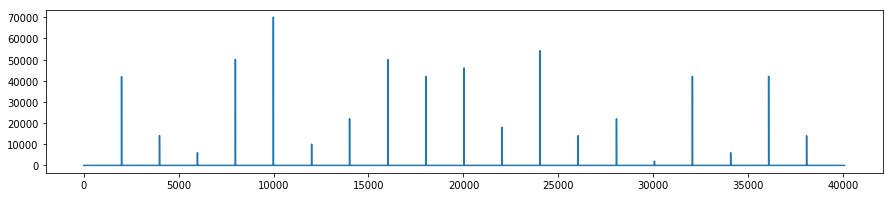

In [6]:
plt.figure(figsize=(15,3))
plt.plot(np.diff(np.array(stims_ecode[4]['EventIndex'])))

In [7]:
# because the length is different, making sure each window is 2000
def make_lfpca(data, stim_ecode, fs, a=0, b=2, n_fft=2000, f_lim=200):
    
    n_chans = data.shape[0]
    
    # locations of where the differences occur
    diff_inds = list(np.where(np.diff(np.array(stim_ecode['EventIndex'])) != 1)[0]+1)    

    #initialize
    start_ind = None
    end_ind = None

    stimdata = data[:,stim_ecode['EventIndex']]
    # 128 channels, all the windows, 2000 in each windows
    f_axis = np.fft.fftfreq(n_fft, 1./fs)
    f_axis = f_axis[:np.where(np.abs(f_axis)>f_lim)[0][0]]
    vg_psd = np.empty((n_chans, len(f_axis), len(diff_inds)),object)
    vg_ft = np.empty((n_chans, len(f_axis), len(diff_inds)),object)
    
    # for every start index, we grab out the chunck 
    for idx, new_start_ind in enumerate(diff_inds):
        # setting the indices of start and end for which we want
        if new_start_ind == diff_inds[0]:
            start_ind = 0
            end_ind = new_start_ind
        elif new_start_ind == diff_inds[-1]:
            start_ind = new_start_ind
            end_ind = len(stim_ecode['ecode'])
        else:
            start_ind = diff_inds[idx-1]
            end_ind = new_start_ind
        inds = stim_ecode['EventIndex'][start_ind:end_ind]
        win = sp.signal.windows.hamming(len(inds)) # applies a hamming window
        
        data_trial = data[:,inds]*win[np.newaxis, :]
        data_trial = data_trial[:, int(a*fs):int(b*fs)]
        ft = np.fft.fft(data_trial, n=n_fft, axis=1, norm='ortho')[:,:len(f_axis)]
        psd = np.abs(ft)**2.
        vg_ft[:,:,idx] = ft
        vg_psd[:,:,idx] = psd
    
    return f_axis, vg_psd, vg_ft
        


/anaconda3/envs/voytek/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


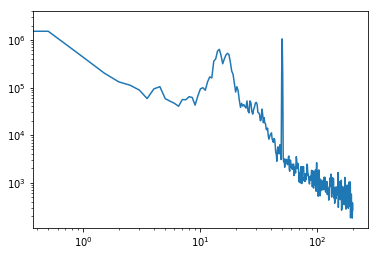

In [18]:
fs = 1000.
f_axis, vg_psd, vg_ft = make_lfpca(data, stims_ecode[1], fs)
plt.loglog(f_axis, vg_psd[0,:,:].mean(axis=1))

analysis_param = {'nperseg': 0,
                  'noverlap': 0,
                  'spg_outlierpct': 1.,
                  'max_freq': 200}

vg_lfpca = lfpca.LFPCA(analysis_param)
vg_lfpca.populate_fourier_data(np.float64(vg_psd), fs, np.float64(f_axis))

In [ ]:
# structure for populating the fourier data [chan x frequency x time]
# go by the conditions
fs = 1000.
saveout_path = "../results/nt_vg/"
for ind, stim_ecode in enumerate(stims_ecode):
    f_axis, vg_psd, vg_ft = make_lfpca(data, stim_ecode, fs)
#   plt.loglog(f_axis, vg_psd[0,:,:].mean(axis=1))

    analysis_param = {'nperseg': int(fs),
                      'noverlap': 0,
                      'spg_outlierpct': 1.,
                      'max_freq': 200}

    vg_lfpca = lfpca.LFPCA(analysis_param)
    vg_lfpca.populate_fourier_data(data=np.float64(vg_psd), fs=fs, f_axis=np.float64(f_axis))
    vg_lfpca.save_spec_vars(saveout_path+'vg_lfpca_'+str(ind)+'.npz', save_spg=True)

### Visualizing the data from the saved

In [3]:
saveout_path = "../results/nt_vg/"
lfpca_files = sorted([f for f in os.listdir(saveout_path) if 'lfpca_' in f])

/anaconda3/envs/voytek/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


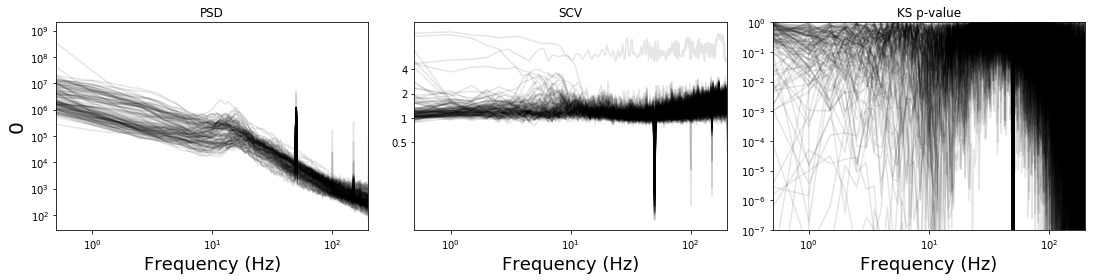

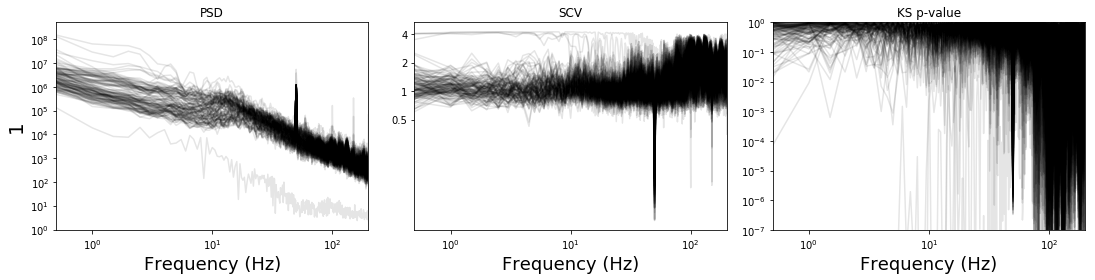

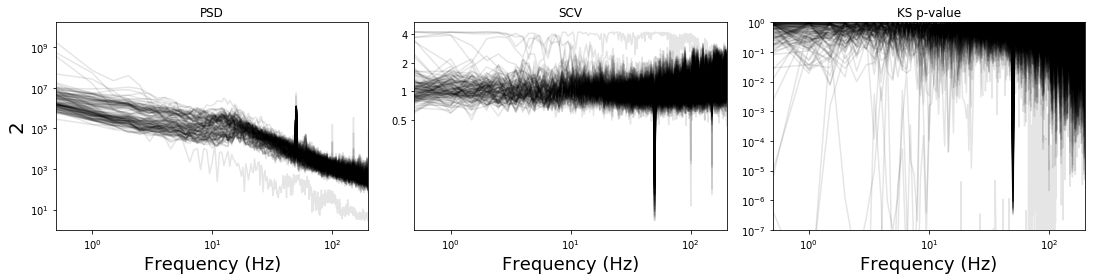

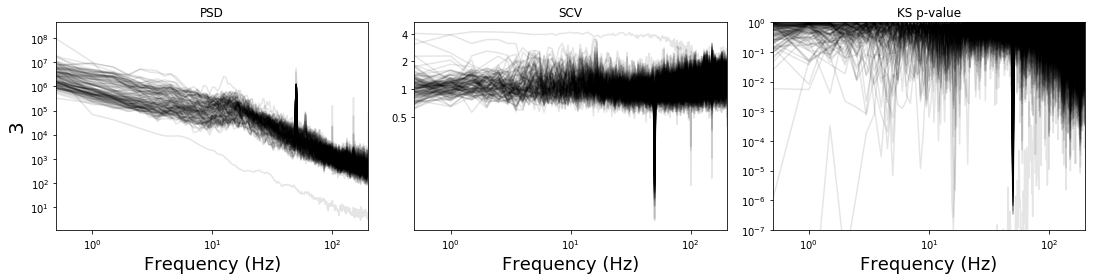

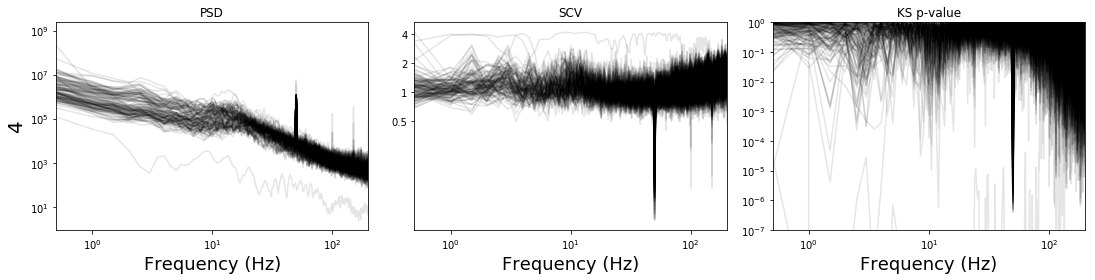

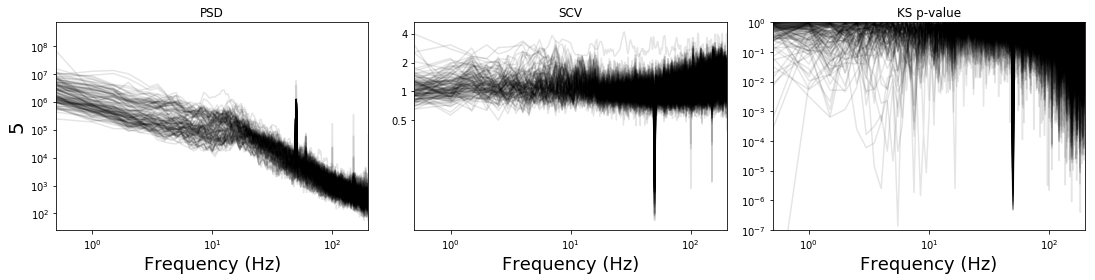

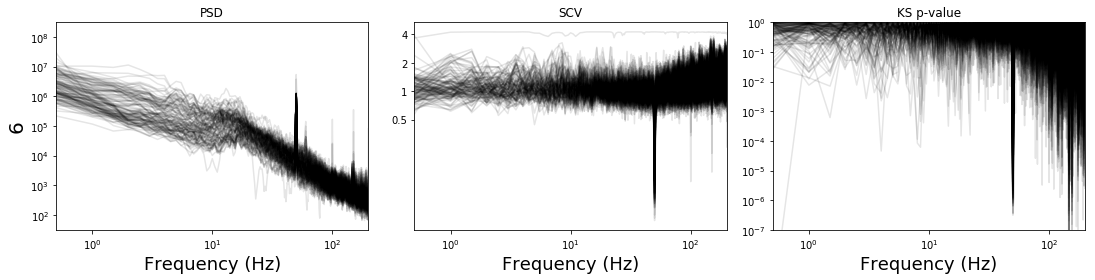

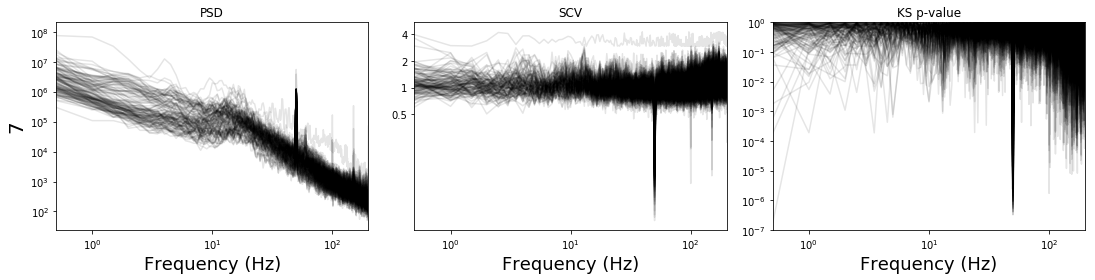

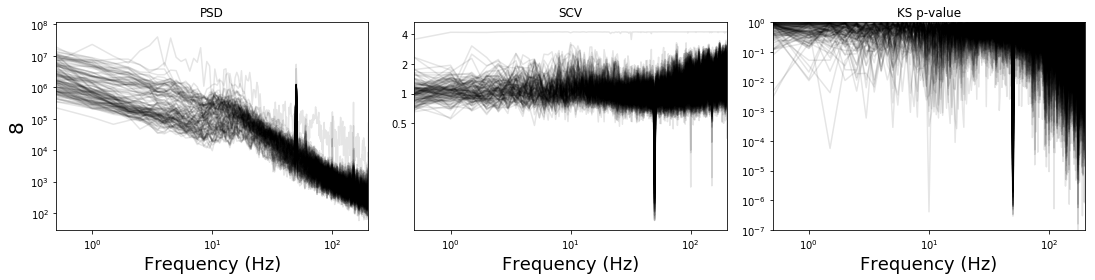

In [4]:
# visualize by separated conditions
lfpca_all = []
for f in range(len(lfpca_files)):
    nt_lfpca = lfpca.lfpca_load_spec(saveout_path+lfpca_files[f])
    lfpca_all.append(nt_lfpca)
    plt.figure(figsize=(15,4))
    nt_lfpca.plot_spectral(plot_mean=False)
    plt.subplot(1,3,1)
    plt.ylabel(lfpca_files[f][9:-4], fontsize=20)

#### Data Information
**Visual Grating Task**
> Monkey was sitting with head fixed. His arm motion was also restrained. 
ECoG data and eye position were recorded. There was a monitor in front of the monkey. 
Grating pattern that moves in eight direction was presented on the screen. 
There was no fixation required. Blank and stimulus pattern were switched alternatively every 2 sec. 
Stimulus events can be decoded from 129th channel by analog value. 
ECoG data were sampled at 1KHz.

* Data Format

    A. ECoG_chN.mat
        ECoGData_chN: ECoG signal (μV) recorded from electrodeN (1‐128), sampled at 1kHZ.
        The Location of electrode is documented in "K2.png".

    B. ECoG_time.mat
        ECoGTime: ECoGTime is a one row-vector contains Time-stamps with the same length as ECoGData_chN.

    C. Event.mat
        EventData: EventData is a one row-vector contains analog input.
        -Analog input format
      Ain indicates event time.
      [   0- 100] : preparation time before experiment
      [ 300- 400] : ITI
      [ 650- 750] : Stimulus 1 ( 45 degree)
      [ 950-1050] : Stimulus 2 ( 90 degree)
      [1300-1400] : Stimulus 3 (135 degree)
      [1600-1700] : Stimulus 4 (180 degree)
      [1950-2050] : Stimulus 5 (225 degree)
      [2250-2350] : Stimulus 6 (270 degree)
      [2600-2700] : Stimulus 7 (315 degree)
      [2900-3000] : Stimulus 8 (360 degree)

    EventTime: EventTime is a one row-vector contains corresponding time-stamp.